# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.


In [4]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sw = stopwords.words('english')
lemma = WordNetLemmatizer()

# **PART 1: WEB SCRAPPING**

In [1]:
def crawl_for_review(pages):
    '''
    Function to scrape british airways airline reviews from www.airlinequality.com
    INPUTS: number of pages
    OUTPUTS: A Json object containing the header,review,loc_time(location and time),rating,recommendation
    '''
    collection = []
    count = 0
    print(f"Scraping started")
    while count < pages:
        page_size = 100
        base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
        url = f"{base_url}/page/{count}/?sortby=post_date%3ADesc&pagesize={page_size}"
        count+=1
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        rating_score = soup.find_all("div",{"class": "rating-10"})[1:]
        profile = soup.find_all("div", {"class": "body"}) 
        for index, passenger in enumerate(profile):
            profile = {}
            rating = rating_score[index].get_text()
            header = passenger.find("h2", {"class": "text_header"}).get_text()
            loc_time = passenger.find("h3", {"class": "text_sub_header"}).get_text()
            review = passenger.find("div",{"class": "text_content"}).get_text()
            table = passenger.find('table',{'class':'review-ratings'})
            recommend = table.find_all('td',{'class':'review-value'})[-1].get_text()
            profile.update([('header',header),
                            ('review',review),
                            ('loc_time',loc_time),
                            ('rating',rating),
                            ('recommend',recommend)])
            collection.append(profile)
        with open ('collection.json','w') as file:
            json.dump(collection,file,indent=3)
    print(f"---> {len(collection)} reviews crawled")
    database = open('collection.json')
    return json.load(database)

# **PART 2: DATA CLEANING**

**Defining functions to clean each column**

In [2]:
def clean_rating(corpus):
    '''' function to clean the rating column '''
    word = re.sub('\n',' ',corpus) # remove new line character
    word = word.split('/')[0] # get the actual rating
    return word
    
def clean_header(corpus):
    ''' function to clean the header column '''
    word = corpus.lower()     # coverting to lower case
    word = re.sub('[^a-zA-Z0-9]',' ',word)     # remove any special character
    word = word_tokenize(word)
    word = ' '.join(lemma.lemmatize(i) for i in word if i not in sw)
    return word

def clean_review(corpus):
    ''' function to clean the review column '''
    word = corpus.split('|')
    if len(word)>1:
       word = word[1] # split on the split verified and discard since we don't need that in the analysis
    else:
        word = word[0]
    word = word.lower() # coverting to lower case
    word = re.sub('[^a-zA-Z0-9]',' ',word)     # remove any special character
    word = word_tokenize(word)
    word = ' '.join(lemma.lemmatize(i) for i in word if i not in sw)
    return word

def clean_loc_time(corpus):
    ''' function to clean the location and time column '''
    full  = corpus.split('(')
    if len(full)>1:
       full = full[1] # split on the split verified and discard since we don't need that in the analysis
    else:
        full = full[0] 
    full = full.split(')')# get the location and date
    return full

def clean_crawled(df):
    ''' applyying the clean functions on thier respective column and returning a cleaned dataframe '''
    df['header'] = df['header'].apply(clean_header)
    df['review'] = df['review'].apply(clean_review)
    df['rating'] = df['rating'].apply(clean_rating)
    split = pd.DataFrame(df['loc_time'].apply(clean_loc_time).tolist(),columns=['country', 'date'])
    df = pd.concat([df, split], axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(['loc_time'],axis=1,inplace=True)
    return df 

In [6]:
reviews = crawl_for_review(35)
df = pd.DataFrame(reviews)
df = clean_crawled(df)
df.head()

,header,review,rating,recommend,country,date
0,cancelled 4 hour take,ba cancelled flight home heathrow dec 19th fac...,1,no,United Kingdom,2022-12-20
1,use airline,ba cancelled flight home last flight day heath...,1,no,United Kingdom,2022-12-19
2,suitcase arrive,turned 3 5 hour advance terminal 5 london heat...,2,no,United Kingdom,2022-12-19
3,cabin crew treated passenger inconvenience,boarding gate lgw called group 1 board world t...,2,no,United Kingdom,2022-12-19
4,luggage finally delivered thursday,missing baggage customer service worst ever ex...,5,no,United States,2022-12-17


**Check for missing values**

In [7]:
df.isna().sum()

header       0
review       0
rating       0
recommend    0
country      0
date         2
dtype: int64

**Drop rows with missing values**

In [8]:
df.dropna(axis=0,inplace=True)

# **PART 3: EDA EXPLORATORY DATA ANALYSIS**

In [9]:
df = df[df['rating']!='\r                         na\r                     ']
df['rating'] = df['rating'].astype(int)

In [10]:
df.dtypes

header               object
review               object
rating                int64
recommend            object
country              object
date         datetime64[ns]
dtype: object

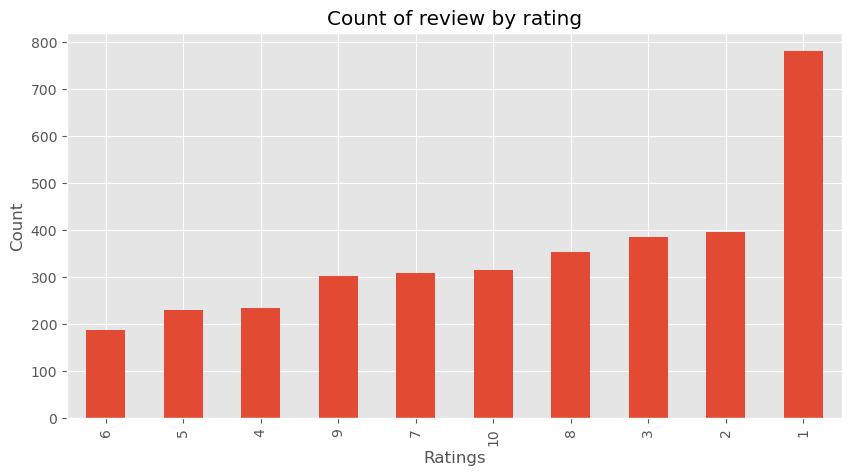

In [11]:
ax = df['rating'].value_counts(ascending=True).plot(kind='bar',figsize=(10,5))
ax.set(title = 'Count of review by rating',
       xlabel ='Ratings',
       ylabel ='Count')
plt.show()

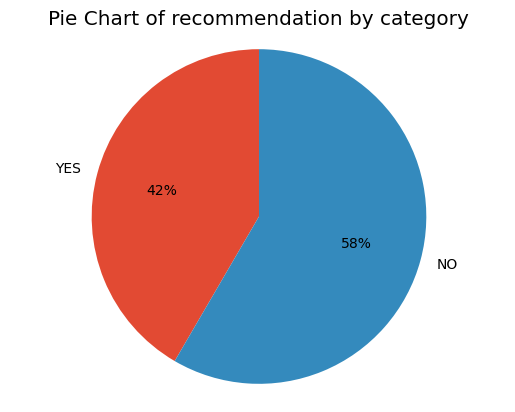

In [87]:
fig = plt.figure()
recommend_yes = df[df['recommend']=='yes']
recommend_no = df[df['recommend']=='no']
x = [len(recommend_yes), len(recommend_no)]
plt.pie(x,labels = ['YES', 'NO'],startangle=90,autopct='%.f%%')
plt.axis('equal')
plt.title('Pie Chart of recommendation by category');

In [94]:
top_10_group = df.groupby(['country']).size().reset_index().sort_values(0, ascending = False).head(10)
top_10_list = top_10_group['country'].tolist()
top_10_country = df[df['country'].isin(top_10_list)]

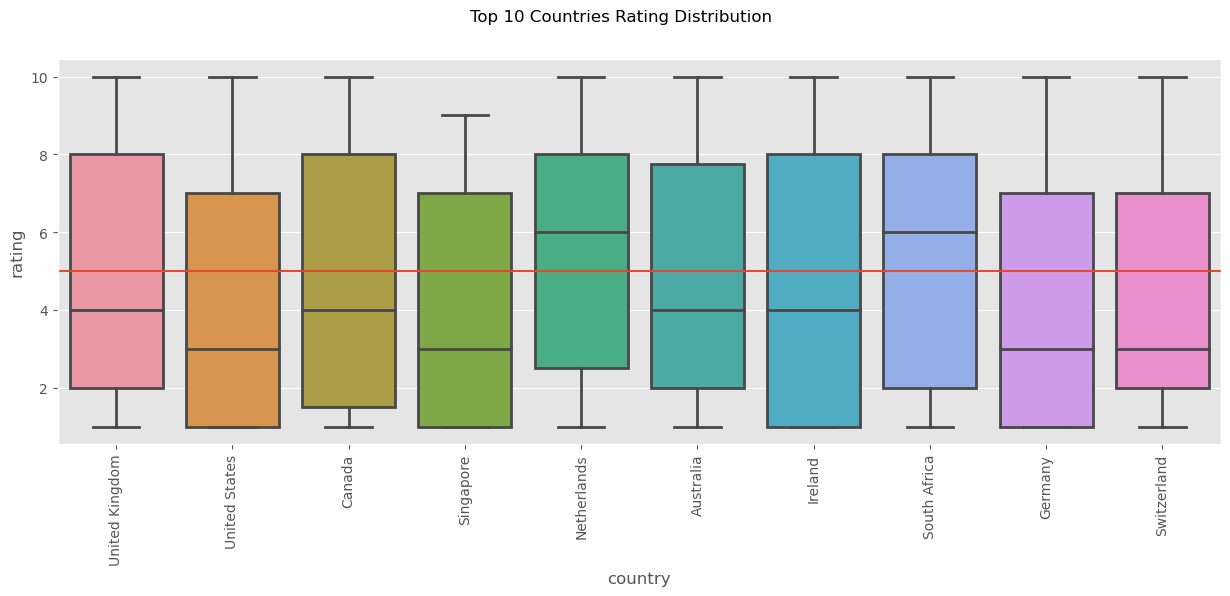

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax = sns.boxplot(x ='country', 
                    y = 'rating', 
                    data = top_10_country, 
                    linewidth = 2) 
ax.axhline(5)
plt.suptitle('Top 10 Countries Rating Distribution') 
plt.xticks(rotation=90)
plt.show()

# **PART 4: SENTIMENT ANALYSIS**

In [80]:
review_yes = recommend_yes['review'].to_list()
review_no = recommend_no['review'].to_list()

**Top 20 Most Common words**

In [84]:
positive = ' '.join(review_yes)
positive_count = Counter(word_tokenize(positive))
positive_count = dict(sorted(positive_count.items(), key=lambda x:x[1],reverse=True))
print(list(positive_count.items())[:20])

[('flight', 2897), ('seat', 1684), ('good', 1464), ('ba', 1428), ('crew', 1115), ('service', 1103), ('time', 1046), ('food', 1021), ('cabin', 935), ('london', 766), ('british', 613), ('heathrow', 607), ('airway', 606), ('lhr', 600), ('drink', 597), ('lounge', 571), ('club', 560), ('economy', 560), ('class', 536), ('staff', 523)]


In [85]:
negative = ' '.join(review_no)
negative_count = Counter(word_tokenize(negative))
negative_count = dict(sorted(negative_count.items(), key=lambda x:x[1],reverse=True))
print(list(negative_count.items())[:20])

[('flight', 4488), ('ba', 3107), ('seat', 2617), ('service', 1716), ('british', 1432), ('airway', 1428), ('london', 1402), ('hour', 1315), ('airline', 1293), ('class', 1292), ('time', 1265), ('food', 1253), ('one', 1106), ('business', 1069), ('cabin', 1060), ('crew', 999), ('would', 982), ('staff', 965), ('get', 962), ('heathrow', 856)]


**function to plot word cloud**

In [21]:
def plot_word_cloud(data:list,title:str):
    '''
    function to plot the world cloud
    '''
    mask = np.array(Image.open('British_Airways-Logo.wine.png'))
    wordcloud = WordCloud(background_color='white',
                        max_words=200,mask=mask,contour_width=3,colormap='rainbow').generate(' '.join(data))
    plt.figure(figsize = (12,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(title)
    plt.axis("off")
    
    return plt.show()

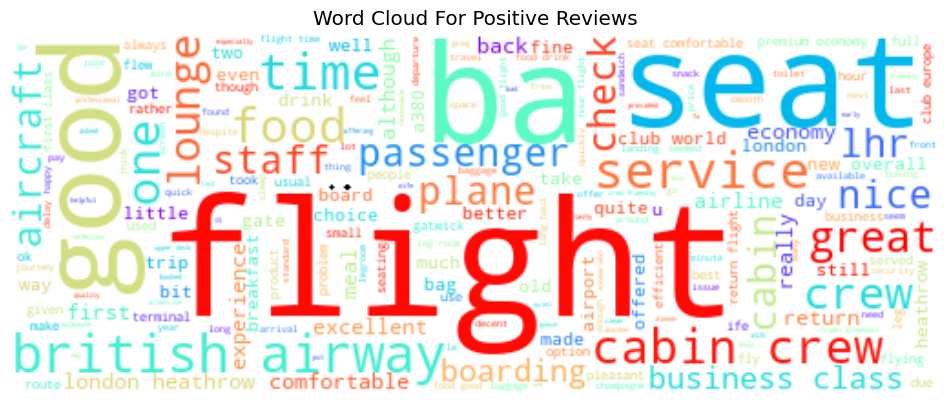

In [22]:
plot_word_cloud(review_yes,'Word Cloud For Positive Reviews')

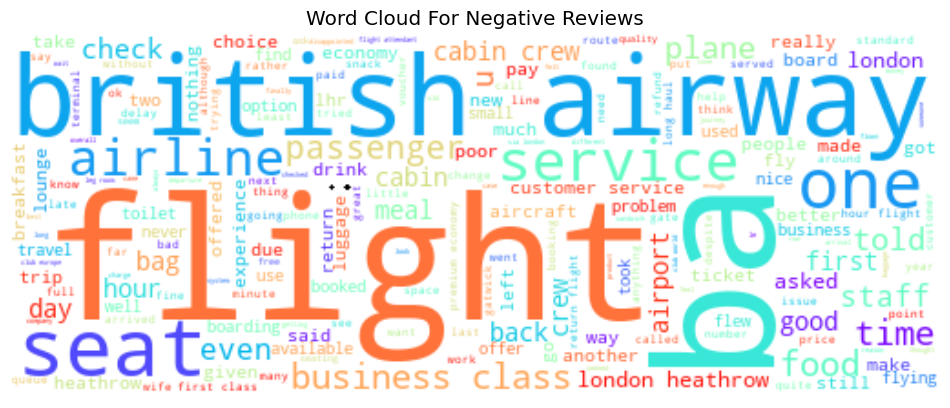

In [23]:
plot_word_cloud(review_no,'Word Cloud For Negative Reviews')

In [26]:
def subjectivity(text): 
    '''
    function to calculate subjectivity score of the review
    '''
    return TextBlob(text).sentiment.subjectivity

def polarity(text): 
    '''
    function to calculate polarity score of the review
    '''
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    ''''
    function to get the review category from the polarity score
    '''
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [27]:
df['subjectivity'] = df['review'].apply(subjectivity)
df['polarity'] = df['review'].apply(polarity)
df['analysis'] = df['polarity'].apply(getAnalysis)

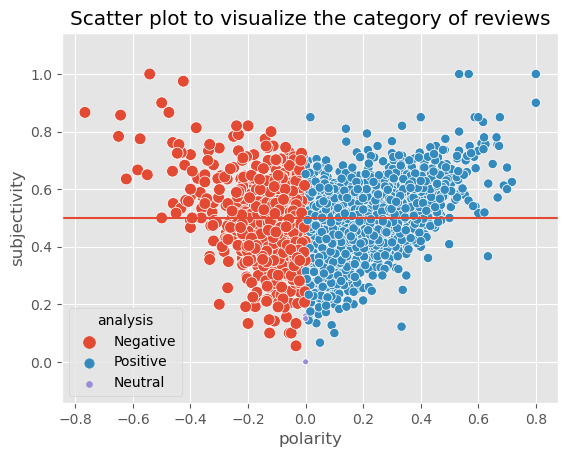

In [29]:
sns.scatterplot(df,
                x ='polarity',
                y='subjectivity',
                hue='analysis',
                size = 'analysis')
plt.axhline(0.5) # add a vertical line at x=0 for Netural Reviews
plt.title('Scatter plot to visualize the category of reviews')
plt.axis('equal')
plt.show()